In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

In [3]:
from scipy.stats import ks_2samp, wasserstein_distance, cramervonmises_2samp

In [4]:
mask= np.load("/neurospin/dico/data/deep_folding/current/datasets/UkBioBank40/crops/2mm/S.C.-sylv./mask/Rmask.npy")

In [5]:
mask.shape

(42, 34, 49, 1)

In [6]:
mask= mask[:,:,:,0]
mask.shape

(42, 34, 49)

In [7]:
input=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/inputs.npy", mmap_mode='r')
output=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/outputs.npy", mmap_mode='r')

In [8]:
input=input[:,0,:,:,:]

In [9]:
output1=output[:,1,:,:,:]

In [10]:
input.shape

(10137, 52, 40, 56)

In [11]:
mask = mask.astype(int)

In [12]:
target_shape = input[0].shape

pad_width = [(0, t - s) for s, t in zip(mask.shape, target_shape)]

mask = np.pad(mask, pad_width, mode='constant', constant_values=0)
mask.shape

(52, 40, 56)

In [13]:
input_hcp=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/hcp/inputs.npy")
output_hcp=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/hcp/outputs.npy")

input_epilepsy=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/epilepsy_PBS/inputs.npy")
output_epilepsy=np.load("/neurospin/dico/fred/Runs/01_betaVAE/Output/2025-10-30/11-29-00/epilepsy_PBS/outputs.npy")

In [14]:
output1_hcp=output_hcp[:,1,:,:,:]
output1_epilepsy=output_epilepsy[:,1,:,:,:]

In [15]:
index_irm_neg = [19,21,26,28,31,34,35,38,40,41,43,44,45]
index_irm_pos=[20,22,23,24,25,27,29,30,32,33,36,37,39,42,46,47,48,49,50,51,52,53,54,55,56]

In [16]:
input_hcp=input_hcp[:,0,:,:,:]
input_epilepsy=input_epilepsy[:,0,:,:,:]

In [28]:
input_control= input_epilepsy[0:19,:,:,:]
output_control= output1_epilepsy[0:19,:,:,:]

input_neg= input_epilepsy[index_irm_neg,:,:,:]
output_neg= output1_epilepsy[index_irm_neg,:,:,:]

input_pos= input_epilepsy[index_irm_pos,:,:,:]
output_pos= output1_epilepsy[index_irm_pos,:,:,:]

Chamfer distance

In [18]:
from scipy.ndimage import distance_transform_edt

In [19]:
def edge_distance_kernel(mask, distance_threshold=5.0, sigma=2.0):
    """
    Compute a spatial weighting kernel emphasizing the center of a binary mask.
    Inside the mask:
      - Weights = 1 for pixels farther than `distance_threshold` from the edge.
      - Weights = Gaussian decay for pixels within `distance_threshold` of the edge.
    Outside the mask:
      - Weights = 0.
    Parameters
    ----------
    mask : np.ndarray
        2D or 3D binary mask defining the valid region (1 inside, 0 outside).
    distance_threshold : float
        Distance (in pixels/voxels) from the mask edge above which weight = 1.
    sigma : float
        Gaussian falloff width (controls how fast the weight decays near edges).
    Returns
    -------
    kernel : np.ndarray
        Weight map of same shape as `mask`, values in [0,1].
    """
    assert mask.ndim in (2, 3), "mask must be 2D or 3D"
    mask = (mask > 0).astype(np.uint8)
    # Compute distance to the nearest 0 (edge)
    dist_inside = distance_transform_edt(mask)
    # Gaussian decay near the edge
    kernel = np.ones_like(mask, dtype=float)
    near_edge = dist_inside < distance_threshold
    kernel[near_edge] = np.exp(-((distance_threshold - dist_inside[near_edge]) ** 2) / (2 * sigma ** 2))
    # Zero weight outside the mask
    kernel[mask == 0] = 0.0
    return kernel

In [20]:
def chamfer_sweep_weighted(
    binary,
    reconstruction,
    threshold,
    kernel=None,
    two_sided=True
):
    """
    Compute weighted Chamfer distance between a binary mask and thresholded
    reconstructions over a range of thresholds.
    Parameters
    ----------
    binary : np.ndarray
        2D or 3D binary ground truth (0/1).
    reconstruction : np.ndarray
        2D or 3D continuous reconstruction in [0,1].
    kernel : np.ndarray or None
        Weighting map of same shape as input. If None, use uniform weights = 1.
    two_sided : bool
        Whether to compute symmetric Chamfer (True) or one-sided (False).
    local_window : int or None
        If None, returns mean error per threshold (scalar).
        If int, compute the sum of weighted error in each valid window
        (no padding) and take the maximum as the score.
    """
    assert binary.shape == reconstruction.shape, "Shapes must match"
    assert binary.ndim in (2, 3), "Supports only 2D or 3D arrays"
    binary = (binary > 0.5).astype(np.uint8)
    if kernel is None:
        kernel = np.ones_like(binary, dtype=float)
    else:
        assert kernel.shape == binary.shape, "Kernel must have same shape as input"
    dist_bin = distance_transform_edt(1 - binary)


    recon_bin = (reconstruction > threshold).astype(np.uint8)
    dist_recon = distance_transform_edt(1 - recon_bin)
    if two_sided:
        error_map = binary * dist_recon + recon_bin * dist_bin
    else:
        error_map = recon_bin * dist_bin
    weighted_error = error_map * kernel

    chamfer_score = weighted_error.mean()

    return chamfer_score

In [21]:
kernel = edge_distance_kernel(mask)

In [22]:
chamfer=[]
thresholds= np.arange(0, 1.05, 0.05)

for t in thresholds:
    L=[]
    for i in range(output1.shape[0]):
        a=chamfer_sweep_weighted(input[i,:,:,:],output1[i,:,:,:],t, kernel)
        L.append(a)
    L=np.array(L)
    chamfer.append(L.mean())
chamfer= np.array(chamfer)

In [23]:
i=np.argmin(chamfer)
i

np.int64(11)

In [24]:
t=i*0.05

In [26]:
input_control.shape

(19, 52, 40, 56)

In [29]:
output_control.shape

(19, 52, 40, 56)

In [30]:
chamfer_ABCD=[]
for i in range(output1.shape[0]):
    chamfer_ABCD.append(chamfer_sweep_weighted(input[i,:,:,:], output1[i,:,:,:],t, kernel))

chamfer_hcp=[]
for i in range(output1_hcp.shape[0]):
    chamfer_hcp.append(chamfer_sweep_weighted(input_hcp[i,:,:,:], output1_hcp[i,:,:,:],t, kernel))

chamfer_control=[]
for i in range(output_control.shape[0]):
    chamfer_control.append(chamfer_sweep_weighted(input_control[i,:,:,:], output_control[i,:,:,:],t, kernel))

chamfer_neg=[]
for i in range(output_neg.shape[0]):
    chamfer_neg.append(chamfer_sweep_weighted(input_neg[i,:,:,:], output_neg[i,:,:,:],t, kernel))

chamfer_pos=[]
for i in range(output_pos.shape[0]):
    chamfer_pos.append(chamfer_sweep_weighted(input_pos[i,:,:,:], output_pos[i,:,:,:],t, kernel))


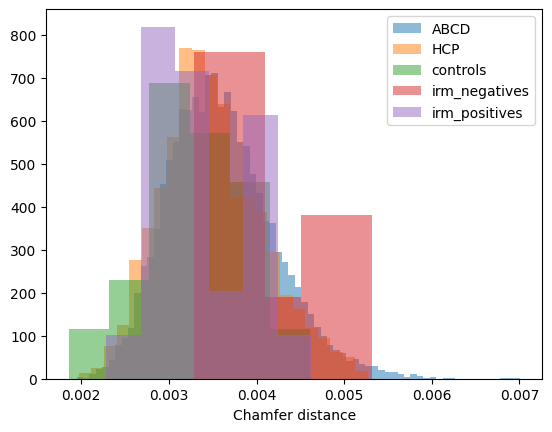

In [31]:
plt.hist(chamfer_ABCD, bins="auto", alpha=0.5, label="ABCD", density=True)
plt.hist(chamfer_hcp, bins="auto", alpha=0.5, label="HCP", density=True)
plt.hist(chamfer_control, bins="auto", alpha=0.5, label="controls", density=True)
plt.hist(chamfer_neg, bins="auto", alpha=0.5, label="irm_negatives", density=True)
plt.hist(chamfer_pos, bins="auto", alpha=0.5, label="irm_positives", density=True)


plt.xlabel("Chamfer distance")

#plt.title("Reconstruction error on subjects with epilepsy")
plt.legend()
plt.show()

AUC

In [32]:
from sklearn.metrics import roc_auc_score

In [33]:
scores = np.concatenate([chamfer_UKB, chamfer_cs])
labels = np.concatenate([np.zeros(len(chamfer_UKB)), np.ones(len(chamfer_cs))])

auc = roc_auc_score(labels, scores)
print(f"AUC = {auc:.3f}")

NameError: name 'chamfer_UKB' is not defined

In [ ]:
#The Kolmogorov-smirnov distance 
print("Between UKB and interrupted_CS:", ks_2samp(chamfer_UKB, chamfer_cs).statistic)
print("Between UKB and hcp:", ks_2samp(chamfer_UKB, chamfer_hcp).statistic)
print("Between UKB and control:", ks_2samp(chamfer_UKB, chamfer_control).statistic)
print("Between UKB and irm_neg:", ks_2samp(chamfer_UKB, chamfer_neg).statistic)
print("Between UKB and irm_pos:", ks_2samp(chamfer_UKB, chamfer_pos).statistic)
print("Between control and hcp:", ks_2samp(chamfer_control, chamfer_hcp).statistic)
print("Between control and irm_neg:", ks_2samp(chamfer_control, chamfer_neg).statistic)
print("Between control and irm_pos:", ks_2samp(chamfer_control, chamfer_pos).statistic)

Between UKB and interrupted_CS: 0.49795132746703896
Between UKB and hcp: 0.5220938608450502
Between UKB and control: 0.5694595746696348
Between UKB and irm_neg: 0.9916165395727751
Between UKB and irm_pos: 0.76599630559371
Between control and hcp: 0.19989605971841634
Between control and irm_neg: 0.8421052631578947
Between control and irm_pos: 0.4568421052631579


In [ ]:
#The Earth Mover’s Distance
print("Between UKB and interrupted_CS:", wasserstein_distance(chamfer_UKB, chamfer_cs))
print("Between UKB and hcp:", wasserstein_distance(chamfer_UKB, chamfer_hcp))
print("Between UKB and control:", wasserstein_distance(chamfer_UKB, chamfer_control))
print("Between UKB and irm_neg:", wasserstein_distance(chamfer_UKB, chamfer_neg))
print("Between UKB and irm_pos:", wasserstein_distance(chamfer_UKB, chamfer_pos))
print("Between control and hcp:", wasserstein_distance(chamfer_control, chamfer_hcp))
print("Between control and irm_neg:", wasserstein_distance(chamfer_control, chamfer_neg))
print("Between control and irm_pos:", wasserstein_distance(chamfer_control, chamfer_pos))

Between UKB and interrupted_CS: 0.002753434821196033
Between UKB and hcp: 0.003724946762745425
Between UKB and control: 0.003780087489067727
Between UKB and irm_neg: 0.01158278739630794
Between UKB and irm_pos: 0.008136288074789935
Between control and hcp: 0.0007767965309600023
Between control and irm_neg: 0.007811353969114809
Between control and irm_pos: 0.004445627825538575
